In [1]:
import sys
import os
sys.path.append('c:/MantidInstall/bin')
from mantid.simpleapi import *
import sans.command_interface.ISISCommandInterface as ici

# save the current state of the default search and save directories
dirs_before = config["datasearch.directories"]
savedir_before = config["defaultsave.directory"]

# set the required search directories and save directory
config["datasearch.directories"] = "E:/temp/ExPaNDS_2/nexus_files/;E:/temp/ExPaNDS_2/mantid-files/;E:/temp/ExPaNDS_2/"
config["defaultsave.directory"] = "E:/temp/ExPaNDS_2/"

# this reduction process will use the ISIS SANS reduction routines and assumes that the 
# appropriate data folders have been setup in the right order in Mantid.
# The saved data and add files will be deposited into the default save folder set in mantid

def reducerun1D(samplesans,sampletrans,cansans,cantrans,direct,maskfile="",savefile=''):
    # define a function to perform the 1d data reduction and save the output workspace
    # in NXCanSAS format
    ici.Clean()
    ici.UseCompatibilityMode()
    ici.LOQ()
    ici.Set1D()
    ici.MaskFile(maskfile)
    ici.AssignSample(samplesans)
    ici.AssignCan(cansans)
    ici.TransmissionSample(sampletrans,direct)
    ici.TransmissionCan(cantrans,direct)
    
    ici.WavRangeReduction(None, None, ici.DefaultTrans)
    SaveNXcanSAS(mtd["{}_main_1D_2.2_10.0".format(samplesans[:5])],"{}_main_1D_2.2_10.0.h5".format(samplesans[:5]))
    if len(savefile)>0:
        SaveNXcanSAS(mtd["{}_main_1D_2.2_10.0".format(samplesans[:5])],savefile+".h5")
        RenameWorkspace("{}_main_1D_2.2_10.0".format(samplesans[:5]),savefile)

In [2]:
# add the seperate data sets together to improve statistics
ici.AddRuns([75884,75892,75921,75932,75943,75954,75965], instrument='LOQ', binning='Monitors')
ici.AddRuns([75883,75891,75920,75931,75942,75953,75964], instrument='LOQ', binning='Monitors')
ici.AddRuns([75882,75890,75919,75930,75941,75952,75963], instrument='LOQ', binning='Monitors')
ici.AddRuns([75881,75889,75918,75929,75940,75951,75962], instrument='LOQ', binning='Monitors')

'The following file has been created:\nLOQ75962-add.nxs'

In [3]:
# reduce the GFP data using the summed data, save and rename the workspaces for saving and plotting
reducerun1D('75965-add.nxs','75876.nxs','75962-add.nxs','75873.nxs','75869.nxs','USER_LOQ_125B.txt','GFP_1mgml')
reducerun1D('75964-add.nxs','75875.nxs','75962-add.nxs','75873.nxs','75869.nxs','USER_LOQ_125B.txt','GFP_5mgml')
reducerun1D('75963-add.nxs','75874.nxs','75962-add.nxs','75873.nxs','75869.nxs','USER_LOQ_125B.txt','GFP_10mgml')

Set1D()
#Opening "E:\temp\ExPaNDS_2\mantid-files\USER_LOQ_125B.txt"
AssignSample("75965-add.nxs")
AssignCan("75962-add.nxs")
TransmissionSample("75876.nxs","75869.nxs")
TransmissionCan("75873.nxs","75869.nxs")
WavRangeReduction(None, None, True)
Set1D()
#Opening "E:\temp\ExPaNDS_2\mantid-files\USER_LOQ_125B.txt"
AssignSample("75964-add.nxs")
AssignCan("75962-add.nxs")
TransmissionSample("75875.nxs","75869.nxs")
TransmissionCan("75873.nxs","75869.nxs")
WavRangeReduction(None, None, True)
Set1D()
#Opening "E:\temp\ExPaNDS_2\mantid-files\USER_LOQ_125B.txt"
AssignSample("75963-add.nxs")
AssignCan("75962-add.nxs")
TransmissionSample("75874.nxs","75869.nxs")
TransmissionCan("75873.nxs","75869.nxs")
WavRangeReduction(None, None, True)


In [4]:
# load the original reduced data from the paper as a check
origGFP_1mgml=LoadCanSAS1D("E:/temp/ExPaNDS_2/original_reduced_data/GFP_1mgml_rear.xml")
origGFP_5mgml=LoadCanSAS1D("E:/temp/ExPaNDS_2/original_reduced_data/GFP_5mgml_rear.xml")
origGFP_10mgml=LoadCanSAS1D("E:/temp/ExPaNDS_2/original_reduced_data/GFP_10mgml_rear.xml")

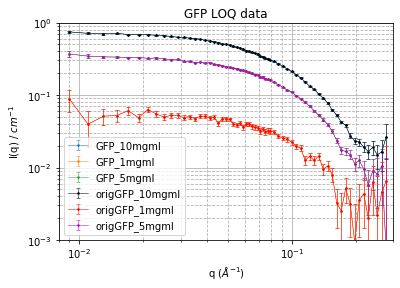

In [5]:
# plot the data.
import matplotlib.pyplot as plt
%matplotlib inline
from mantid.api import AnalysisDataService as ADS

GFP_1mgml = ADS.retrieve('GFP_1mgml')
GFP_5mgml = ADS.retrieve('GFP_5mgml')
GFP_10mgml = ADS.retrieve('GFP_10mgml')
origGFP_1mgml = ADS.retrieve('origGFP_1mgml')
origGFP_5mgml = ADS.retrieve('origGFP_5mgml')
origGFP_10mgml = ADS.retrieve('origGFP_10mgml')

fig, axes = plt.subplots(edgecolor='#ffffff', num='GFP LOQ data', subplot_kw={'projection': 'mantid'})
axes.errorbar(GFP_10mgml, capsize=2.0, capthick=0.5, color='#1f77b4', elinewidth=0.5, label='GFP_10mgml', linewidth=0.5, marker='.', markersize=3.0, specNum=1)
axes.errorbar(GFP_1mgml, capsize=2.0, capthick=0.5, color='#ff7f0e', elinewidth=0.5, label='GFP_1mgml', linewidth=0.5, marker='.', markersize=3.0, specNum=1)
axes.errorbar(GFP_5mgml, capsize=2.0, capthick=0.5, color='#2ca02c', elinewidth=0.5, label='GFP_5mgml', linewidth=0.5, marker='.', markersize=3.0, specNum=1)
axes.errorbar(origGFP_10mgml, capsize=2.0, capthick=0.5, color='k', elinewidth=0.5, label='origGFP_10mgml', linewidth=0.5, marker='.', markersize=3.0, specNum=1)
axes.errorbar(origGFP_1mgml, capsize=2.0, capthick=0.5, color='r', elinewidth=0.5, label='origGFP_1mgml', linewidth=0.5, marker='.', markersize=3.0, specNum=1)
axes.errorbar(origGFP_5mgml, capsize=2.0, capthick=0.5, color='m', elinewidth=0.5, label='origGFP_5mgml', linewidth=0.5, marker='.', markersize=3.0, specNum=1)
axes.set_title('GFP LOQ data')
axes.set_xlabel('q ($\AA^{-1}$)')
axes.set_ylabel('I(q) / $cm^{-1}$')
axes.set_xlim([0.008, 0.3])
axes.set_ylim([0.001, 1.0])
axes.set_xscale('log')
axes.set_yscale('log')
axes.grid()
axes.grid(b=True, which='minor', linestyle='--')
axes.legend()

In [6]:
# reset the search and save directories to their original values
config["datasearch.directories"] = dirs_before
config["defaultsave.directory"] = savedir_before